# Trabalho da Materia de Tópicos Especiais em Linguagem de Programação (TELP)

### Aluno: Gabriel Pamponet


## Análise do Desenvolvimento de Projetos a partir de Repositórios do GitHub

##1. Introdução

Nesse trabalho foram anasilados três repositórios: Scikit-learn, Flask e Numpy. Todas elas são bibliotecas do Python, e cada uma tem sua finalidade específica.


Para cada Biblioteca, foi analisado a taxa de falhas a partir das mudanças implantadas junto com a frequência de deploys que foram analisadas a partir dos pull request que foram meslados aos frameworks, a fim de medir a qualidade das entregas dos contribuidores conforme a variação entre as duas metricas.

##2. Desenvolvimento

###2.1 Taxa de falha nas mudanças e deploy frequency

###2.1.1 Flask

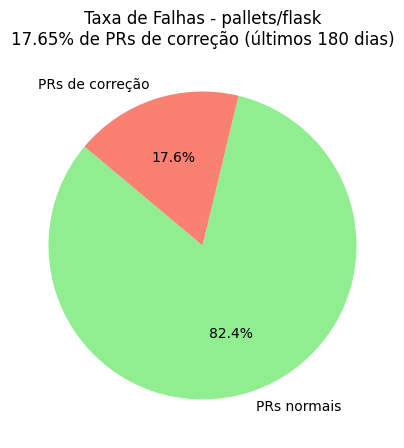

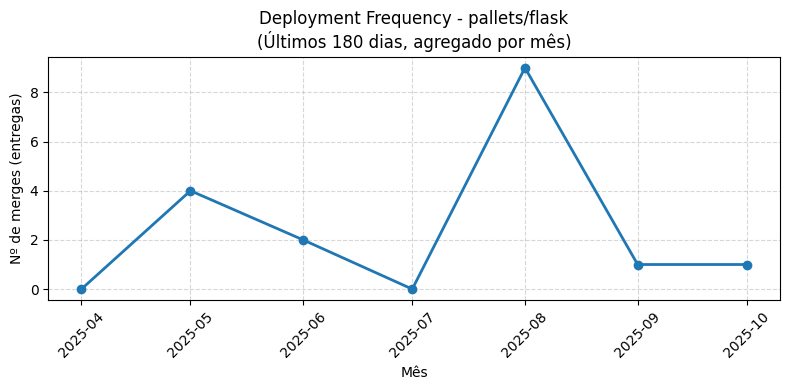

Analisando os gráficos do Flask podemos perceber que no periodo de 180 dias, observa-se que tiveram um número pequeno de deploys, tambem é possivel observar que existe um pico de deploys no mês 5 e no mês 8 se estabilizando após esses periodos, isso sugere que sejam melhorias no framework ou adição de novas funcionalidades e depois houve uma estabilidade nas entregas, já a taxa de falha também tem um número pequeno com apenas 17,6%. Isso mostra que os contribuidores fazem menos modificações, porém de forma mais precisa e assertiva.


##2.1.1 Numpy

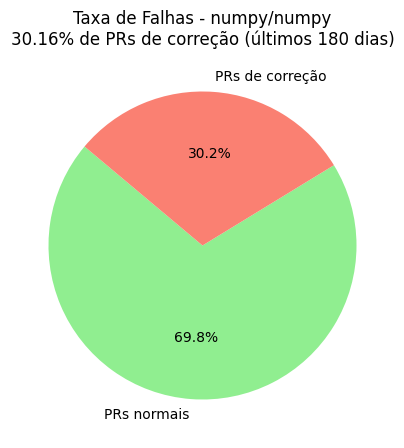

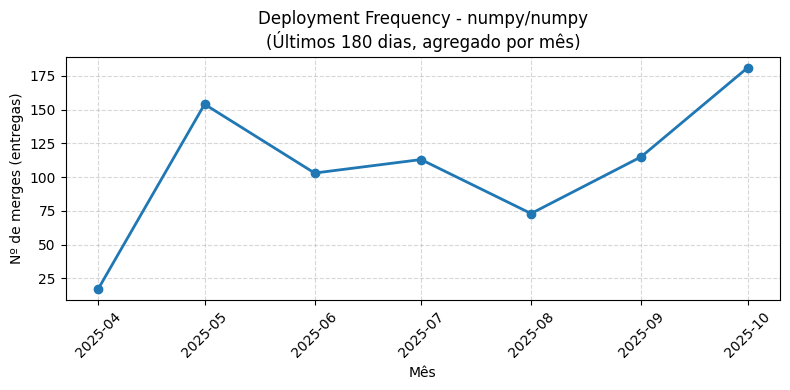

Analisando os gráficos do Numpy podemos perceber que no mês de abril para maio, teve um grande aumento de deploys tendo uma leve queda apenas no mês de agosto mas logo em seguida voltou a crescer atigindo sua maior quantidade no mês de outubro, além de que a taxa de falha das mudanças implantadas é alta chegando aos 30,2%. Observa-se que com repentino crescimento do número de deploys junto com a alta taxa de falha, com isso é perceptivel que os contribuidores fazem entregas de forma rápida e com muitas instabilidades.

## 2.1.3 Scikit-Learn

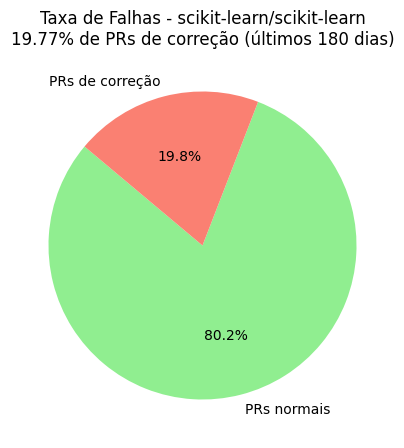

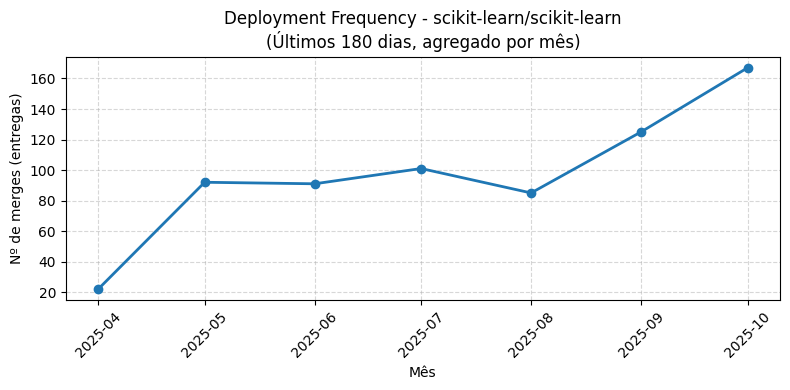


Analisando os gráficos do scikit-learn podemos perceber que durante os 180 dias analisados, houve um crescimento continuo no número de deploys mesmo tendo um periodo de estabilidade no numero de entregas os deploys continuaram a crescer, mostrando que o flask tem contribuidores engajados e experientes sempre adicionando ou melhorando o framework, isso se intencifica analisando a taxa de falha do scikit-learn que chega apenas aos 19.8%. Isso mostra que mesmo com um número alto de deploys a taxa de falha foi pequena, com isso vemos que os contribuidores entregam de forma rápida, contínua e com qualidade.

##3. Conclusão

Com isso podemos perceber o nível de entrega dos contribuidores e a velociade que elas são implantadas. O Flask apresenta um baixo número de deploys e baixa taxa de falha, indicando que os contribuidores realizam poucas mudanças mas com assertividade.

O Numpy se mostra o oposto, com o crescimento no número de deploys e com uma grande taxa de falha, mostrando que os contribuidores entregam rápido e de forma instavél.

Já o scikit_learn tambem apresenta um grande número de deploys mas com uma taxa de falha baixa, mostrando que os contribuidores entregam de forma rápida e com poucas falhas.

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import time

GIT_HUB_TOKEN = "seu_token_aqui"
#Token de acesso ao GitHub API e os Repositorios para analise
REPOS = [
    "pallets/flask",
    "numpy/numpy",
    "scikit-learn/scikit-learn"
]
DAYS = 180

HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"}
BASE_URL = "https://api.github.com/repos"


def get_json(url):
    """Requisição segura com token."""
    r = requests.get(url, headers=HEADERS)
    if r.status_code == 200:
        return r.json()
    else:
        print(f"Erro {r.status_code} ao acessar {url}")
        return None


def get_merged_prs_last_days(repo, days=DAYS):
    """Obtém PRs merged nos últimos X dias via endpoint de busca (mais confiável)."""
    time_limit = (datetime.now(timezone.utc) - timedelta(days=days)).date()
    all_prs = []
    page = 1

    while True:
        query = f"repo:{repo}+is:pr+is:merged+merged:>={time_limit}"
        url = f"https://api.github.com/search/issues?q={query}&per_page=100&page={page}"
        data = get_json(url)

        if not data or "items" not in data:
            break

        all_prs.extend(data["items"])

        if len(data["items"]) < 100:
            break

        page += 1

        time.sleep(1.5)

    return all_prs

def calculate_failure_rate(repo, days=DAYS):
    """Calcula a Change Failure Rate considerando PRs merged nos últimos X dias."""
    prs = get_merged_prs_last_days(repo, days)
    if not prs:
        return None

    merged_prs = [pr for pr in prs if pr.get("closed_at")]
    merged_total = len(merged_prs)

    if merged_total == 0:
        return None

    fix_keywords = ["fix", "bug", "revert", "patch", "hotfix", "repair", "resolve"]
    fix_prs = [
        pr for pr in merged_prs
        if any(kw in pr["title"].lower() for kw in fix_keywords)
    ]

    fix_count = len(fix_prs)
    failure_rate = round((fix_count / merged_total) * 100, 2)

    return {
        "repo": repo,
        "period_days": days,
        "total_merged_prs": merged_total,
        "fix_related_prs": fix_count,
        "failure_rate_%": failure_rate
    }

#Tabela com: Repositorios/ Dias/ merged pull requests/ fix pull requests/ taxa de falha
def data_frame_failure_rate(result):
  if results:
    df = pd.DataFrame(results)
    print("Change Failure Rate - Últimos 180 dias:")
    display(df)
  else:
    print("Nenhum dado disponível.")

#Gráficos de taxa de falha
def plot_failure_rate(result):
  for result in results:
    repo_name = result["repo"]
    labels = ['PRs normais', 'PRs de correção']
    values = [result['total_merged_prs'] - result['fix_related_prs'], result['fix_related_prs']]

    plt.figure(figsize=(5,5))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140,
            colors=["lightgreen", "salmon"])
    plt.title(f"Taxa de Falhas - {repo_name}\n{result['failure_rate_%']}% de PRs de correção (últimos {DAYS} dias)")
    plt.show()

#Metrica de deployment frequency
def calculate_deployment_frequency(repo, days=DAYS):
  """Calcula número de PRs merged (entregas) e frequência mensal."""
  prs = get_merged_prs_last_days(repo, days)

  merged_dates_str = [pr.get("closed_at") for pr in prs if pr.get("closed_at")]

  total = len(merged_dates_str)

  per_month = round(total / (days / 30.44), 2)
  return {
    "repo": repo,
    "period_days": days,
    "total_merges": total,
    "per_month_avg": per_month,
    "merged_dates_str": merged_dates_str
  }

#Tabelas com: Repositorios/ Dias/ total de merges/ média por mês
def data_frame_deployment_frequency(result):
  if results:
    df = pd.DataFrame(results)
    print("Deployment Frequency - Últimos 180 dias:")
    display(df)
  else:
    print("Nenhum dado disponível.")

def plot_deployment_frequency(result):
  for result in results:
    repo_name = result["repo"]
    dates_str = result["merged_dates_str"]

    if not dates_str:
      print(f"Nenhum merge encontrado em {repo_name}.")
      continue


    df_dates = pd.DataFrame(dates_str, columns=["closed_at"])
    df_dates["closed_at"] = pd.to_datetime(df_dates["closed_at"], utc=True)

    df_dates["month"] = df_dates["closed_at"].dt.to_period("M").apply(lambda r: r.start_time)
    freq_by_month = df_dates.groupby("month").size()

    start_date = (datetime.now(timezone.utc) - timedelta(days=DAYS)).replace(day=1)
    all_months = pd.period_range(start=start_date, end=datetime.now(timezone.utc), freq="M")
    freq_by_month = freq_by_month.reindex(all_months.to_timestamp(), fill_value=0)

    plt.figure(figsize=(8,4))
    plt.plot(freq_by_month.index, freq_by_month.values, marker="o", linewidth=2)
    plt.title(f"Deployment Frequency - {repo_name}\n(Últimos {DAYS} dias, agregado por mês)")
    plt.xlabel("Mês")
    plt.ylabel("Nº de merges (entregas)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Gráfico de comparação entre os repositorios na metrica deployment frequency
def plot_comparsion_deployment_frequency(result):
  monthly_comparison = {}
  start_date = (datetime.now(timezone.utc) - timedelta(days=DAYS)).replace(day=1, hour=0, minute=0, second=0, microsecond=0)
  end_date = datetime.now(timezone.utc)
  all_months_index = pd.period_range(start=start_date, end=end_date, freq="M").to_timestamp()

  for result in results:
    repo_name = result["repo"].split('/')[1]
    dates_str = result["merged_dates_str"]

    if not dates_str:
      print(f"Nenhum merge encontrado em {repo_name} para o gráfico de comparação.")
      monthly_comparison[repo_name] = pd.Series(0, index=all_months_index)
      continue

    df_dates = pd.DataFrame(dates_str, columns=["closed_at"])

    df_dates["closed_at"] = pd.to_datetime(df_dates["closed_at"], utc=True)

    freq_by_month = df_dates.groupby(df_dates["closed_at"].dt.to_period("M")).size()

    freq_by_month.index = freq_by_month.index.to_timestamp()

    freq_by_month = freq_by_month.reindex(all_months_index, fill_value=0)

    monthly_comparison[repo_name] = freq_by_month

  df_comparison = pd.DataFrame(monthly_comparison)

  plt.figure(figsize=(12, 6))

  df_comparison.plot(ax=plt.gca(), marker='o', linewidth=2)

  plt.title(f"Comparação de Deployment Frequency (Merges) - Últimos {DAYS} dias", fontsize=14)
  plt.xlabel("Mês", fontsize=12)
  plt.ylabel("Nº de Merges (Entregas)", fontsize=12)
  plt.grid(True, linestyle="--", alpha=0.5)
  plt.legend(title="Repositório", loc='upper left')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


results = []
for repo in REPOS:
    print(f"→ Analisando {repo} ...")
    res = calculate_failure_rate(repo, DAYS)
    if res:
        results.append(res)


#Tabelas com: Repositorios/ Dias/ merged pull requests/ fix pull requests/ taxa de falha
data_frame_failure_rate(results)
plot_failure_rate(results)

results = []
print(f"\nCalculando Deployment Frequency (últimos {DAYS} dias)...")
for repo in REPOS:
  res = calculate_deployment_frequency(repo, DAYS)
  results.append(res)

data_frame_deployment_frequency(results)
plot_deployment_frequency(results)
plot_comparsion_deployment_frequency(results)


